In [205]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter, defaultdict
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

#gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
from gensim.models import NormModel

#spacy for lemmatization
import spacy
import en_core_web_sm

from xgboost import XGBClassifier, plot_importance
from sklearn.preprocessing import OneHotEncoder, scale, LabelEncoder
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/preethiseshadri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [209]:
def predict_loo(clf, X_train, y_train, X_test, y_test):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    clf.fit(X_train, y_train.ravel())
    y_pred_tr = clf.predict(X_train)
    y_pred_ts = clf.predict(X_test)
    return y_pred_tr, y_pred_ts

def compute_metrics(actual, pred):
    accuracy = metrics.accuracy_score(actual, pred)
    precision = metrics.precision_score(actual, pred)
    recall = metrics.recall_score(actual, pred)
    auc = metrics.roc_auc_score(actual, pred)
    return accuracy, precision, recall, auc

In [210]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopWords] for doc in texts]

def make_bigrams_dvd(texts):
    return [bigram_mod_dvd[doc] for doc in texts]

def make_trigrams_dvd(texts):
    return [trigram_mod_dvd[bigram_mod_dvd[doc]] for doc in texts]

def make_bigrams_va(texts):
    return [bigram_mod_va[doc] for doc in texts]

def make_trigrams_dvd(texts):
    return [trigram_mod_va[bigram_mod_va[doc]] for doc in texts]

nlp = en_core_web_sm.load(disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out   

In [211]:
stopWords = stopwords.words('english')
stopWords = set([word.replace("'", "") for word in stopWords])
stopWords = stopWords.union(set(["taiwan", "taiwanese", "communist", "mmmhmm", "'", "'cause", "'em", 'a', 'aa', 'aaah', 'aah', 'ab', 'about', 'above', 'african', 'after', 'again', 'against', 'ah', 'ahh', 'ahhh', 'ahhhh', 'ahhm', 'ain', 'aint', 'alabama', 'alaska', 'all', 'alot', 'alright', 'alrighty', 'also', 'am', 'an', 'anand', 'and', 'andand', 'any', 'anyone', 'are', 'aren', 'arent', 'as', 'at', 'ay', 'b', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'bye', 'c', 'california', 'came', 'can', 'cant', 'clean', 'costa_rica', 'could', 'couldn', 'couldnt', 'cuz', 'd', 'de', 'did', 'didn', 'didnt', 'do', 'doc', 'does', 'doesn', 'doesnt', 'doin', 'doing', 'dokey', 'don', 'dont', 'down', 'during', 'e', 'each', 'eek', 'eh', 'em', 'er', 'et', 'etc', 'europe', 'f', 'few', 'florida','for', 'from', 'further', 'g', 'ga', 'gal', 'gee', 'geez', 'germany', 'get', 'go', 'goin', 'going', 'gonna', 'gosh', 'got', 'gotta', 'greek', 'gu', 'h', 'ha', 'had', 'hadn', 'hadnt', 'has', 'hasn', 'hasnt', 'have', 'haven', 'havent', 'having', 'he', 'hed', 'heh', 'hell', 'hello', 'henry', 'her', 'here', 'hers', 'herself', 'hes', 'hey', 'hi', 'him', 'himself', 'his', 'hm', 'hmm', 'hmmm', 'hodgkins', 'how', 'hows', 'huh', 'hum', 'i', 'id', 'if', 'ifif', 'ii', 'iii', 'ill', 'im', 'imrt', 'in', 'inaudible', 'indecipherable', 'indianapolis', 'into', 'is', 'isis', 'isn', 'isnt', 'it', 'itd', 'itit', 'itll', 'its', 'itself', 'ive', 'j', 'jeez', 'just', 'k', 'kay', 'kinda', 'l', 'laughs', 'le', 'leastno', 'legend', 'let', 'lets', 'like', 'll', 'look', 'lot', 'm', 'ma', 'maam', 'md', 'mdmd', 'me', 'mhm', 'mhmm', 'mhmmm', 'michigan', 'mightn', 'mightnt', 'mightve', 'mkay', 'mm', 'mmhm', 'mmhmm', 'mmkay', 'mmm', 'mmmhmm','mmmhmmm', 'mmmm', 'mmmmm', 'more', 'most', 'mustn', 'mustnt', 'mustve', 'my', 'myself', 'n', 'na', 'nah', 'nahuh', 'nd', 'ne', 'needn', 'neednt', 'nn', 'no', 'nooh', 'noooo', 'nope', 'nor', 'not', 'now', 'o', 'of', 'off', 'oh', 'ohh', 'ohhh', 'ohhhohohohoh', 'ohio', 'ok', 'okay', 'okey', 'on', 'once', 'only', 'oooh', 'or', 'oth', 'other', 'othumhmm', 'oughta', 'our', 'ours', 'ourselves', 'out', 'over', 'ow', 'own', 'p', 'patient', 'phi', 'physician', 'potter', 'pt', 'pt/so', 'q', 'r', 'rd', 're', 'right', 'ro', 's', 'said', 'same', 'say', 'see', 'shan', 'shant', 'she', 'shell', 'shes', 'should', 'shouldn', 'shouldnt', 'shouldve', 'so', 'some', 'sorta', 'sounds', 'st', 'stuff', 'such', 'swedish', 't', 'th', 'than', 'that', 'thatd', 'thatll', 'thats', 'thatsthat', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'thered', 'thereof', 'theres', 'thereve', 'these', 'thethe', 'thew', 'they', 'theyll', 'theyre', 'theyve', 'thing', 'things', 'this', 'those', 'through', 'ti', 'to', 'too', 'tthe', 'u', 'uh', 'uhh', 'uhhhhh', 'uhhm', 'uhhmm', 'uhhuh', 'uhm', 'uhmhmm', 'uhmhmmm', 'uhmmm', 'uhoh', 'uhum', 'um', 'umhmm', 'umhmmm', 'umm', 'ummm', 'ummmm', 'un', 'under', 'unhunh', 'until', 'up', 'us', 'uuh', 'v', 've', 'very', 'vietnam', 'virginia', 'w', 'walsh', 'wanna', 'was', 'washington', 'wasn', 'wasnt', 'we', 'wed', 'well', 'went', 'were', 'weren', 'werent', 'weve', 'wewe', 'what', 'whatd', 'whatev', 'whatever', 'whatnot', 'whats', 'when', 'where', 'wheres', 'whew', 'which', 'while', 'who', 'whoa', 'whom', 'whos', 'why', 'will', 'with', 'won', 'wont', 'would', 'wouldn', 'wouldnt', 'x', 'y', 'ya', 'yada', 'yah', 'yall', 'yea', 'yeah', 'yep', 'yepvery', 'yer', 'yeyeah', 'you', 'youd', 'youl', 'youll', 'your', 'youre', 'yours', 'yourself', 'yourselves', 'youve', 'youyou', 'yup', 'z']))
print("We have", len(stopWords), "stop words.")

We have 432 stop words.


# Baseline + Topics

In [245]:
df = pd.read_csv('dvd_withAdvice_final.csv')

# Subset the dataframe
lda_models = []
factors_all = ["age", "gleason", "DVD", "TxChoice2_orig", "Convo_1", "as1", "sur1", "rad1"]
factors_sub = ["age", "gleason", "DVD", "TxChoice2_orig", "Convo_1"]
df = df.dropna(subset=factors_all)
X = df[factors_sub]
y = df["txgot_binary"]
X = np.array(X)
y = np.array(y)

In [246]:
len(X)

131

In [244]:
# Process the transcripts
convo_dvd = df["Convo_1"]
data_words_dvd = list(sent_to_words(convo_dvd))
bigram_dvd = gensim.models.Phrases(data_words_dvd, min_count=2, threshold=100) 
bigram_mod_dvd = gensim.models.phrases.Phraser(bigram_dvd)
data_words_nostops_dvd = remove_stopwords(data_words_dvd)
data_words_bigrams_dvd = make_bigrams_dvd(data_words_nostops_dvd)
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized_dvd = lemmatization(data_words_bigrams_dvd, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_dvd = [[word for word in convo if word not in stopWords] for convo in data_lemmatized_dvd]

In [247]:
# Run leave-one-out cross-validation
predictions_ts = []
accuracy_tr = []
precision_tr = []
recall_tr = []
auc_tr = []
max_depth = 3
subsample = 1
no_below = 0.1
no_above = 0.95
keep_n = 5000
loo = LeaveOneOut()
index = 1
for train_index, test_index in loo.split(X):
    #first split up the dataset
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create Bag of words model
    texts_lemmatized = np.array(data_lemmatized_dvd)
    id2word_dvd = corpora.Dictionary(texts_lemmatized[train_index]) # build corpus on training data only
    id2word_dvd.filter_extremes(no_below = no_below, no_above = no_above, keep_n = keep_n, keep_tokens = None)

    corp_dvd = [id2word_dvd.doc2bow(text) for text in texts_lemmatized]
    corp_dvd = np.array(corp_dvd)

    # Split corpus
    corp_dvd_train = corp_dvd[train_index]
    corp_dvd_test = corp_dvd[test_index]

    #LDA Model
    lda_model_dvd = gensim.models.ldamodel.LdaModel(corpus=corp_dvd_train,
                                           id2word=id2word_dvd,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=3,
                                           chunksize=20,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    lda_models.append(lda_model_dvd)
    
    #convert testing and training to dataframe so can append distributions
    X_train = pd.DataFrame({'age':X_train[:,0],'gleason':X_train[:,1], "DVD": X_train[:,2], "TxChoice2_orig": X_train[:, 3], 'Convo_1': X_train[:, 4]})
    X_test = pd.DataFrame({'age':X_test[:,0],'gleason':X_test[:,1],"DVD": X_test[:,2], "TxChoice2_orig": X_test[:, 3], 'Convo_1': X_test[:, 4]})

    # get training distributions
    distributions = lda_model_dvd[corp_dvd_train]
    dvd_length = len(corp_dvd_train) 
    topic0 = [0] * dvd_length
    topic1 = [0] * dvd_length
    topic2 = [0] * dvd_length
    topic3 = [0] * dvd_length
    topic4 = [0] * dvd_length
    topic5 = [0] * dvd_length
    topic6 = [0] * dvd_length
    topic7 = [0] * dvd_length
    # store the topic percentage values for training
    for en, row in enumerate(distributions):
        topics = row[0]
        for topic in topics:
            if topic[0] == 0:
                topic0[en] = topic[1]
            elif topic[0] == 1:
                topic1[en] = topic[1]
            elif topic[0] == 2:
                topic2[en] = topic[1]
            elif topic[0] == 3:
                topic3[en] = topic[1]
            elif topic[0] == 4:
                topic4[en] = topic[1]
            elif topic[0] == 5:
                topic5[en] = topic[1]
            elif topic[0] == 6:
                topic6[en] = topic[1]
            elif topic[0] == 7:
                topic7[en] = topic[1]
    X_train['topic0'] = topic0
    X_train['topic1'] = topic1
    X_train['topic2'] = topic2
    X_train['topic3'] = topic3
    X_train['topic4'] = topic4
    X_train['topic5'] = topic5
    X_train['topic6'] = topic6
    X_train['topic7'] = topic7

    # get testing distributions
    distributions = lda_model_dvd[corp_dvd_test]
    dvd_length = len(corp_dvd_test) 
    topic0 = [0] * dvd_length
    topic1 = [0] * dvd_length
    topic2 = [0] * dvd_length
    topic3 = [0] * dvd_length
    topic4 = [0] * dvd_length
    topic5 = [0] * dvd_length
    topic6 = [0] * dvd_length
    topic7 = [0] * dvd_length
    # store the topic percentage values for testing
    for en, row in enumerate(distributions):
        topics = row[0]
        for topic in topics:
            if topic[0] == 0:
                topic0[en] = topic[1]
            elif topic[0] == 1:
                topic1[en] = topic[1]
            elif topic[0] == 2:
                topic2[en] = topic[1]
            elif topic[0] == 3:
                topic3[en] = topic[1]
            elif topic[0] == 4:
                topic4[en] = topic[1]
            elif topic[0] == 5:
                topic5[en] = topic[1]
            elif topic[0] == 6:
                topic6[en] = topic[1]
            elif topic[0] == 7:
                topic7[en] = topic[1]
    X_test['topic0'] = topic0
    X_test['topic1'] = topic1
    X_test['topic2'] = topic2
    X_test['topic3'] = topic3
    X_test['topic4'] = topic4
    X_test['topic5'] = topic5
    X_test['topic6'] = topic6
    X_test['topic7'] = topic7

    X_train = X_train[["age", "gleason", "DVD", "TxChoice2_orig", "topic0", "topic1", "topic2", "topic3", "topic4", "topic5", "topic6", "topic7"]]
    X_test = X_test[["age", "gleason", "DVD", "TxChoice2_orig", "topic0", "topic1", "topic2", "topic3", "topic4", "topic5", "topic6", "topic7"]]
 
    xgb = XGBClassifier(max_depth = max_depth, subsample = subsample)
    y_pred_tr, y_pred_ts = predict_loo(xgb, X_train, y_train, X_test, y_test)
    predictions_ts.append(y_pred_ts)
    
    # training
    acc, prec, rec, auc = compute_metrics(y_train, y_pred_tr)
    accuracy_tr.append(acc)
    precision_tr.append(prec)
    recall_tr.append(rec)
    auc_tr.append(auc)
    
    clear_output(wait=True)
    print('finished round ', index)
    index += 1

finished round  131


In [248]:
# training performance
print('training accuracy: ', np.average(accuracy_tr))
print('training precision: ', np.average(precision_tr))
print('training recall: ', np.average(recall_tr))
print('training auc: ', np.average(auc_tr))

# testing performance
accuracy, precision, recall, auc = compute_metrics(y, predictions_ts)
print('testing accuracy: ', accuracy)
print('testing precision: ', precision)
print('testing recall: ', recall)
print('testing auc ', auc)

training accuracy:  0.985613623018203
training precision:  0.9955818504173335
training recall:  0.9414144073001667
training auc:  0.9700972724279535
testing accuracy:  0.8244274809160306
testing precision:  0.6206896551724138
testing recall:  0.6
testing auc  0.7455445544554457


## New Convo_1 Performance

Max_depth = 3, No_below = 0.1, No_above = 1, keep_n = 5000
+ training accuracy: 0.991, training precision: 0.995, training recall: 0.967, training auc 0.983
+ testing accuracy: 0.756, testing precision: 0.464, testing recall: 0.433, testing auc: 0.642

Max_depth = 3, No_below = 0.1, No_above = 0.9, keep_n = 5000
+ training accuracy:  0.985, training precision:  0.996, training recall:  0.940, training auc:  0.9694231
+ testing accuracy:  0.794, testing precision:  0.556, testing recall:  0.5, testing auc  0.691

Max_depth = 3, subsample = 0.9, no_below = 0.1, no_above = 0.75, keep_n = 5000
+ training accuracy:  0.994, training precision:  0.999, training recall:  0.974, training auc:  0.987
+ testing accuracy:  0.794, testing precision:  0.579, testing recall:  0.367, testing auc  0.644

Max_depth = 3, No_below = 0.1, No_above = 0.95, keep_n = 7000
+ training accuracy:  0.988, training precision:  0.999, training recall:  0.950, training auc:  0.975
+ testing accuracy:  0.771, testing precision:  0.5, testing recall:  0.467, testing auc  0.664

Max_depth = 3, Subsample = 0.9, No_below = 0.1, No_above = 0.95, Keep_n = 5000
+ training accuracy:  0.9863769817968291, training precision:  0.997289621674859, training recall:  0.9432131262612968, training auc:  0.9712248837413355, testing accuracy:  0.816793893129771, testing precision:  0.6071428571428571, testing recall:  0.5666666666666667, testing auc  0.7288778877887788

Max_depth = 3, No_below = 0.1, No_above = 0.95, Keep_n = 5000
+ training accuracy:  0.986, training precision:  0.996, training recall:  0.942, training auc:  0.970
+ testing accuracy:  0.824, testing precision:  0.621, testing recall:  0.6, testing auc  0.746

Max_depth = 3, No_below = 0.1, No_above = 0.95, Keep_n = 4000
+ training accuracy:  0.993, training precision:  1.0, training recall:  0.969, training auc:  0.984
+ testing accuracy:  0.802, testing precision:  0.583, testing recall:  0.467, testing auc  0.684

# Baseline + Advice

In [ ]:
df = pd.read_csv('dvd_withAdvice_final.csv')

# Subset the dataframe
lda_models = []
factors_all = ["age", "gleason", "DVD", "TxChoice2_orig","Convo_1", "as1", "sur1", "rad1"]
factors_sub = ["age", "gleason", "DVD", "TxChoice2_orig","as1", "sur1", "rad1"]
df = df.dropna(subset=factors_all)
X = df[factors_sub]
y = df["txgot_binary"]
X = np.array(X)
y = np.array(y)

# Run leave-one-out cross-validation
predictions_ts = []
accuracy_tr = []
precision_tr = []
recall_tr = []
auc_tr = []
max_depth = 3
loo = LeaveOneOut()
index = 1
for train_index, test_index in loo.split(X):
    #first split up the dataset
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = pd.DataFrame({'age':X_train[:,0],'gleason':X_train[:,1], "DVD": X_train[:,2], "TxChoice2_orig": X_train[:, 3], 'as1': X_train[:, 4], 'sur1': X_train[:, 5], 'rad1': X_train[:, 6]})
    X_test = pd.DataFrame({'age':X_test[:,0],'gleason':X_test[:,1], "DVD": X_test[:,2], "TxChoice2_orig": X_test[:, 3], 'as1': X_test[:, 4], 'sur1': X_test[:, 5], 'rad1': X_test[:, 6]})
    
    X_train = X_train[["age", "gleason", "DVD", "TxChoice2_orig", "as1", "sur1", "rad1"]]
    X_test = X_test[["age", "gleason", "DVD", "TxChoice2_orig", "as1", "sur1", "rad1"]]
 
    xgb = XGBClassifier(max_depth = max_depth)
    y_pred_tr, y_pred_ts = predict_loo(xgb, X_train, y_train, X_test, y_test)
    predictions_ts.append(y_pred_ts)
    
    # training
    acc, prec, rec, auc = compute_metrics(y_train, y_pred_tr)
    accuracy_tr.append(acc)
    precision_tr.append(prec)
    recall_tr.append(rec)
    auc_tr.append(auc)
    
    print('finished round ', index)
    index += 1

In [ ]:
# training performance
print('training accuracy: ', np.average(accuracy_tr))
print('training precision: ', np.average(precision_tr))
print('training recall: ', np.average(recall_tr))
print('training auc: ', np.average(auc_tr))

# testing performance
accuracy, precision, recall, auc = compute_metrics(y, predictions_ts)
print('testing accuracy: ', accuracy)
print('testing precision: ', precision)
print('testing recall: ', recall)
print('testing auc ', auc)

## Baseline + Advice Performance

Max_depth = 3
+ training accuracy:  0.9619495008807987, training precision:  0.92926528531484, training recall:  0.9028428533824692, training auc:  0.941176169341072
+ testing accuracy:  0.8091603053435115, testing precision:  0.5925925925925926, testing recall:  0.5333333333333333, testing auc  0.7122112211221121

# Baseline

In [ ]:
df = pd.read_csv('dvd_withAdvice_final.csv')

# Subset the dataframe
lda_models = []
factors_all = ["age", "gleason", "DVD", "TxChoice2_orig","Convo_1", "as1", "sur1", "rad1"]
factors_sub = ["age", "gleason", "DVD", "TxChoice2_orig"]
df = df.dropna(subset=factors_all)
X = df[factors_sub]
y = df["txgot_binary"]
X = np.array(X)
y = np.array(y)
print('Shape :', X.shape)

# Run leave-one-out cross-validation
predictions_ts = []
accuracy_tr = []
precision_tr = []
recall_tr = []
auc_tr = []
max_depth = 3
loo = LeaveOneOut()
index = 1
for train_index, test_index in loo.split(X):
    #first split up the dataset
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = pd.DataFrame({'age':X_train[:,0],'gleason':X_train[:,1], "DVD": X_train[:,2], "TxChoice2_orig" : X_train[:, 3]})
    X_test = pd.DataFrame({'age':X_test[:,0],'gleason':X_test[:,1], "DVD": X_test[:,2], "TxChoice2_orig" : X_test[:, 3]})
    
    X_train = X_train[["age", "gleason", "DVD", "TxChoice2_orig"]]
    X_test = X_test[["age", "gleason", "DVD", "TxChoice2_orig"]]
    
    xgb = XGBClassifier(max_depth = max_depth)
    y_pred_tr, y_pred_ts = predict_loo(xgb, X_train, y_train, X_test, y_test)
    predictions_ts.append(y_pred_ts)
    
    # training
    acc, prec, rec, auc = compute_metrics(y_train, y_pred_tr)
    accuracy_tr.append(acc)
    precision_tr.append(prec)
    recall_tr.append(rec)
    auc_tr.append(auc)
    
    print('finished round ', index)
    index += 1

In [ ]:
# training performance
print('training accuracy: ', np.average(accuracy_tr))
print('training precision: ', np.average(precision_tr))
print('training recall: ', np.average(recall_tr))
print('training auc: ', np.average(auc_tr))

# testing performance
accuracy, precision, recall, auc = compute_metrics(y, predictions_ts)
print('testing accuracy: ', accuracy)
print('testing precision: ', precision)
print('testing recall: ', recall)
print('testing auc ', auc)

## Baseline Performance

Max_depth = 3
+ training accuracy:  0.8826189078097477, training precision:  0.8552019941132032, training recall:  0.5868737387031676, training auc:  0.7786602084793897
+ testing accuracy:  0.7938931297709924, testing precision:  0.56, testing recall:  0.4666666666666667, testing auc:  0.6788778877887789

## Feature Importances

In [249]:
df = pd.read_csv('dvd_withAdvice_final.csv')

# Subset the dataframe
lda_models = []
factors_all = ["age", "gleason", "DVD", "TxChoice2_orig", "Convo_1", "as1", "sur1", "rad1"]
factors_sub = ["age", "gleason", "DVD", "TxChoice2_orig", "Convo_1"]
df = df.dropna(subset=factors_all)
X = df[factors_sub]
y = df["txgot_binary"]
X = np.array(X)
y = np.array(y)

# Remove stopwords, create bigrams/trigrams, lemmatize everything
convo_dvd = df["Convo_1"]
data_words_dvd = list(sent_to_words(convo_dvd))
bigram_dvd = gensim.models.Phrases(data_words_dvd, min_count=2, threshold=100) 
bigram_mod_dvd = gensim.models.phrases.Phraser(bigram_dvd)
data_words_nostops_dvd = remove_stopwords(data_words_dvd)
data_words_bigrams_dvd = make_bigrams_dvd(data_words_nostops_dvd)
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized_dvd = lemmatization(data_words_bigrams_dvd, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_dvd = [[word for word in convo if word not in stopWords] for convo in data_lemmatized_dvd]

In [250]:
# Set parameters
max_depth = 3
subsample = 1
no_below = 0.1
no_above = 0.95
keep_n = 5000

# Build Corpus
texts_lemmatized = np.array(data_lemmatized_dvd)
id2word_dvd = corpora.Dictionary(texts_lemmatized) # build corpus on entire dataset
id2word_dvd.filter_extremes(no_below = no_below, no_above = no_above, keep_n = keep_n, keep_tokens = None)
corp_dvd = [id2word_dvd.doc2bow(text) for text in texts_lemmatized]
corp_dvd = np.array(corp_dvd)

# Create LDA Model with corpus from above
lda_model_dvd = gensim.models.ldamodel.LdaModel(corpus=corp_dvd,
                                       id2word=id2word_dvd,
                                       num_topics=8, 
                                       random_state=100,
                                       update_every=3,
                                       chunksize=20,
                                       passes=10,
                                       alpha='auto',
                                       per_word_topics=True)


X = pd.DataFrame({'age':X[:,0],'gleason':X[:,1], "DVD": X[:,2], "TxChoice2_orig": X[:, 3], 'Convo_1': X[:, 4]})
# Get topic distributions for entire dataset
distributions = lda_model_dvd[corp_dvd]
dvd_length = len(corp_dvd) 
topic0 = [0] * dvd_length
topic1 = [0] * dvd_length
topic2 = [0] * dvd_length
topic3 = [0] * dvd_length
topic4 = [0] * dvd_length
topic5 = [0] * dvd_length
topic6 = [0] * dvd_length
topic7 = [0] * dvd_length
# Store the topic percentage values
for en, row in enumerate(distributions):
    topics = row[0]
    for topic in topics:
        if topic[0] == 0:
            topic0[en] = topic[1]
        elif topic[0] == 1:
            topic1[en] = topic[1]
        elif topic[0] == 2:
            topic2[en] = topic[1]
        elif topic[0] == 3:
            topic3[en] = topic[1]
        elif topic[0] == 4:
            topic4[en] = topic[1]
        elif topic[0] == 5:
            topic5[en] = topic[1]
        elif topic[0] == 6:
            topic6[en] = topic[1]
        elif topic[0] == 7:
            topic7[en] = topic[1]
# Create new columns in dataframe with topic distributions
X['topic0'] = topic0
X['topic1'] = topic1
X['topic2'] = topic2
X['topic3'] = topic3
X['topic4'] = topic4
X['topic5'] = topic5
X['topic6'] = topic6
X['topic7'] = topic7

# Subset dataframe for model training 
X = X[["age", "gleason", "DVD", "TxChoice2_orig", "topic0", "topic1", "topic2", "topic3", "topic4", "topic5", "topic6", "topic7"]]

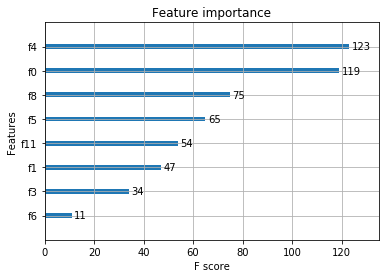

['topic0', 0.23295455]
['age', 0.22537878]
['topic4', 0.14204545]
['topic1', 0.12310606]
['topic7', 0.10227273]
['gleason', 0.08901515]
['TxChoice2_orig', 0.06439394]
['topic2', 0.020833334]
['topic6', 0.0]
['topic5', 0.0]
['topic3', 0.0]
['DVD', 0.0]


In [251]:
from matplotlib import pyplot
clf = XGBClassifier(max_depth = max_depth)
X_np = np.array(X)
clf.fit(X_np, y)
plot_importance(clf)
pyplot.show()

sorted_idx = np.argsort(clf.feature_importances_)[::-1]
for index in sorted_idx:
    print([X.columns[index], clf.feature_importances_[index]]) 

In [254]:
print("DVD Topics:")
pprint(lda_model_dvd.print_topics(num_words=30))

DVD Topics:
[(0,
  '0.009*"kind" + 0.009*"check" + 0.008*"feel" + 0.008*"erection" + '
  '0.006*"help" + 0.006*"psa" + 0.006*"guy" + 0.006*"everything" + '
  '0.006*"control" + 0.006*"work" + 0.006*"remove" + 0.005*"recovery" + '
  '0.005*"doctor" + 0.005*"still" + 0.005*"side" + 0.005*"pretty" + '
  '0.005*"bladder" + 0.005*"surveillance" + 0.005*"young" + 0.005*"use" + '
  '0.004*"catheter" + 0.004*"nice" + 0.004*"fine" + 0.004*"meet" + '
  '0.004*"high" + 0.004*"urinary" + 0.004*"ahead" + 0.004*"robotic" + '
  '0.004*"decision" + 0.004*"sometimes"'),
 (1,
  '0.012*"risk" + 0.010*"kind" + 0.009*"treat" + 0.008*"psa" + '
  '0.008*"actually" + 0.007*"high" + 0.007*"put" + 0.006*"low" + 0.006*"use" + '
  '0.006*"urinary" + 0.006*"different" + 0.006*"gleason" + 0.006*"work" + '
  '0.006*"side_effect" + 0.005*"start" + 0.005*"try" + 0.005*"even" + '
  '0.005*"gland" + 0.005*"less" + 0.005*"still" + 0.005*"study" + 0.004*"dose" '
  '+ 0.004*"seed" + 0.004*"maybe" + 0.004*"feel" + 0.004*"re